# Western Governors University
## D213 - Advanced Data Analysis - Time Series Modeling
### Shane Boyce

### Part I:  Research Question

#### A.  Describe the purpose of this data analysis by doing the following:

1. Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

Based on past revenue, what is the expected revenue for the next quarter?

3. Define the objectives or goals of the data analysis. Ensure that your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

Using multiple samples of time series data, we will be able to predict the revenue for the next quarter. If the data can be made stationary, we will be able to use the ARIMA model to predict the revenue for the next quarter from daily data.

### Part II:  Method Justification

#### B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

Time Series data is assumed to be Gaaussian (normally distributed).

Time Series requires that data have stationarity, which means that the mean, variance, and autocorrelation structure are constant over the time series chosen structure of time (day/month/year et cet).

Autocorrelated data is data that is correlated with itself over time.  This can be seen in the data by looking at the autocorrelation plot and measured by the autocorrelation coefficient which is the correlation between the data and a lagged version of itself. It is interpreted as a Pearson correlation coefficient between the data and a lagged version of itself.



### Part III:  Data Preparation


In [1]:
# Import libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
#magic function to display plots in the notebook
%matplotlib inline
df = pd.read_csv('teleco_time_series .csv', index_col='Day', parse_dates=True)
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


#### Data Preparation

Will verify data and make a few resamples to get a better understanding of the data.

In [2]:
df.shape

(731, 1)

In [3]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [4]:
#check for null values and duplicates
df.isnull().any()

Revenue    False
dtype: bool

In [5]:
df.duplicated().sum()

0

In [6]:
#change day to date, since no start date is given, January 1st, 2020 will be used.
df.index = pd.date_range(start='2020-01-01', periods=731, freq='D')
df.head()

,Revenue
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554


In [7]:
#work on a copy DF
daily = df.copy()

In [8]:
#first month daily mean to verify monthly resample
daily['2020-01-01':'2020-01-31'].mean()

Revenue    1.350632
dtype: float64

In [9]:
#first quarter daily mean to verify quarterly resample
daily['2020-01-01':'2020-03-31'].mean()


Revenue    3.019389
dtype: float64

array([[<AxesSubplot:title={'center':'Revenue'}>]], dtype=object)

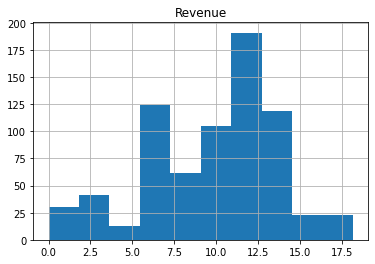

In [10]:
#view distribution of data daily, monthly, quarterly, and yearly
df.hist()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 27.6 KB


In [12]:
#check for null values
df.isnull().sum()

Revenue    0
dtype: int64

In [13]:
#check for duplicates
df.duplicated().sum()

0

<AxesSubplot:xlabel='Revenue'>

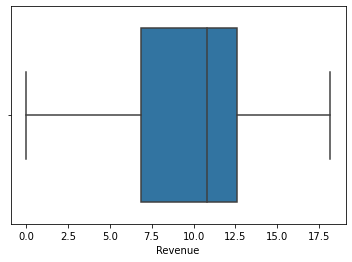

In [14]:
#check for outliers
sns.boxplot(x=df['Revenue'])
#probably not treating outliers as they are not extreme

In [15]:
#verify places where revenue is 0
df[df['Revenue'] == 0]

,Revenue
2020-01-01,0.0


There is one line where revenue is 0, but it is the first day of the data set.  This is likely due to the fact that the data was not collected until the second day or no revenue was collected on the first day.  This will be left as is.

### C.  Summarize the data cleaning process by doing the following:

### 1.  Provide a line graph visualizing the realization of the time series.

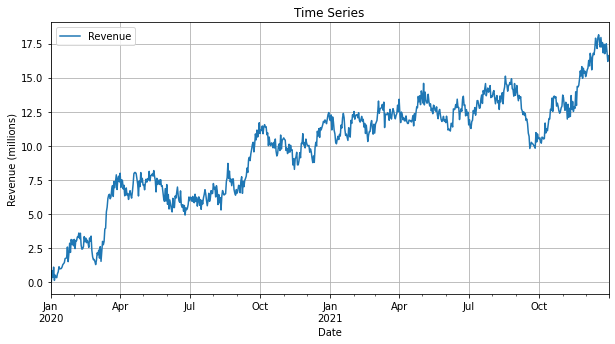

In [16]:
df.plot(grid=True, figsize=(10,5))
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Revenue (millions)')
plt.show()

### 2. Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.

The dataset did not have any null values or duplicates, so there is no treatment necessary for any gaps.


### 3.  Evaluate the stationarity of the time series.


In [17]:
#evaluation imports
#check for stationarity
from statsmodels.tsa.stattools import adfuller
#compare fuller to kpss
from statsmodels.tsa.stattools import kpss
#acf plot
from statsmodels.graphics.tsaplots import plot_acf
#pacf plot
from statsmodels.graphics.tsaplots import plot_pacf
#import warnings filter for readability
import warnings
warnings.filterwarnings('ignore')

The daily and monthly steps appear to not be stationary. In order to verify, an ADF and KPSS test will be run on the data with an $a$ = 0.05. If we reject H0 of the ADF and do not reject H0 of the KPSS, we can conclude that the data is stationary, otherwise the data is not stationary.

In [18]:
def adf_kpss(df):
    '''This function will take in a dataframe and return the results of the Augmented Dickey Fuller and KPSS tests.
    This results will determine based on P-value one of the following cases:
    Case 1: Unit root test: you can’t reject H0; KPSS test: reject H0. Both imply that series has unit root.
    Case 2: Unit root test: Reject H0. KPSS test: don`t reject H0. Both imply that series is stationary.
    Case 3 If we can’t reject both test: data give not enough observations.
    Case 4 Reject unit root, reject stationarity: both hypothesis are component hypothesis.

    https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests
    '''

    #Augmented Dickey Fuller and KPSS tests
    adf = adfuller(df)
    kpss_result = kpss(df)
    print(f'Statstic: Augmented Dickey Fuller: {adf[1]}, KPSS: {kpss_result[1]}'
          f'\nP-value: Augmented Dickey Fuller: {adf[0]}, KPSS: {kpss_result[0]}'
          f'\nCritical Values:\nAugmented Dickey Fuller:{adf[4]}\nKPSS: {kpss_result[3]}\n\n')


    #case statements to determine stationarity, unit root and potential next steps
    if (adf[1] < .05) & (kpss_result[1] > .05):
        print('Case 2: Unit root test: Reject H0. KPSS test: don`t reject H0. Both imply that series is stationary.')
    else:
        print('Data is not stationary. Use .diff() to make data stationary and run test again.')

#### ADF and KPS Test
Below the ADF and KPSS test will be run on the daily and monthly data. The results will be interpreted and next steps will be determined based on the results.

In [19]:
adf_kpss(daily)

Statstic: Augmented Dickey Fuller: 0.3205728150793969, KPSS: 0.01
P-value: Augmented Dickey Fuller: -1.9246121573101826, KPSS: 3.5607139300692454
Critical Values:
Augmented Dickey Fuller:{'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Data is not stationary. Use .diff() to make data stationary and run test again.


As suspected, the daily data is not stationary. The next step will be to make the data stationary by using the .diff() method. The ADF and KPSS test will be run again to verify the data is stationary.

### 4.  Explain the steps used to prepare the data for analysis, including the training and test set split.

In [20]:
#make data stationary via .diff()
daily_diff = daily.diff()
daily_diff.dropna(inplace=True)
adf_kpss(daily_diff)

Statstic: Augmented Dickey Fuller: 0.0, KPSS: 0.1
P-value: Augmented Dickey Fuller: -44.87452719387599, KPSS: 0.0667878999007167
Critical Values:
Augmented Dickey Fuller:{'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Case 2: Unit root test: Reject H0. KPSS test: don`t reject H0. Both imply that series is stationary.


<AxesSubplot:>

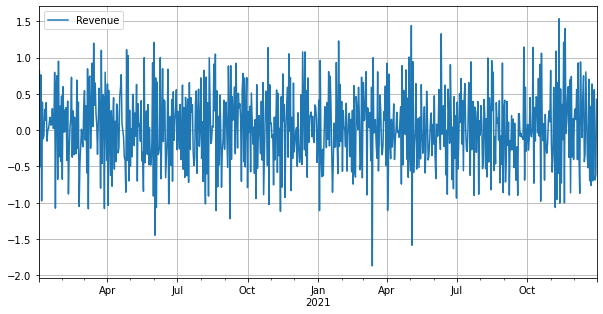

In [21]:
#verify data is stationary visually
daily_diff.plot(grid=True, figsize=(10,5))

The data has been converted to stationary and looks like white noise. The next step will be to split the data into train and test sets. The train set will be 80% of the data and the test set will be 20% of the data.

In [22]:
#stationary data to csv
daily_diff.to_csv('daily_diff.csv')

In [23]:
#test train split for daily, monthly and quarterly both quarterly data, roughly 80/20 split

#daily
dailytrain = daily[:'2021-08-08']
dailytest = daily['2021-08-09':]


dailydiftrain = daily_diff[:'2021-08-08']
dailydiftest = daily_diff['2021-08-09':]

In [24]:
#verify train test split, should print out 2 True statments
len(dailytest)+len(dailytrain)==len(daily), len(dailydiftest)+len(dailydiftrain)==len(daily_diff)

(True, True)

Data was imported from CSV using pandas and converted to datetime format. The data was then resampled into daily, monthly, quarterly and yearly dataframes. The daily and monthly dataframes were converted to stationary data using differencing. The quarterly and yearly dataframe was discarded from use after seeing low number of observations. The useful data (day and month) were then split into training and test sets. The training sets will be used to train the model and the test set will be used to test the model.The training set comprises ~80% (closest to 80% without being under) of the data and the test set is the remainder of the data for the daily and monthly models.

### 5.  Provide a copy of the cleaned dataset.

diff data already saved to csv, adding train and test data to csvs

In [25]:
#add train and test data to csvs
dailytrain.to_csv('dailytrain.csv')
dailytest.to_csv('dailytest.csv')
dailydiftrain.to_csv('dailydiftrain.csv')
dailydiftest.to_csv('dailydiftest.csv')

### Part IV:  Model Identification and Analysis

#### D.  Analyze the time series dataset by doing the following:

1.  Report the annotated findings with visualizations of your data analysis, including the following elements:

•   the presence or lack of a seasonal component


The data visually shows no seasonality from before treatment or after. THis can be verified with the Decompose function from statsmodels later in the notebook.

•   trends

All data trended upward over time. The data was converted to stationary data to remove the trend, the ADF and KPS tests show that the data is stationary and the visual trend is not significant or can be treated with an ARIMA model.

•   auto correlation function



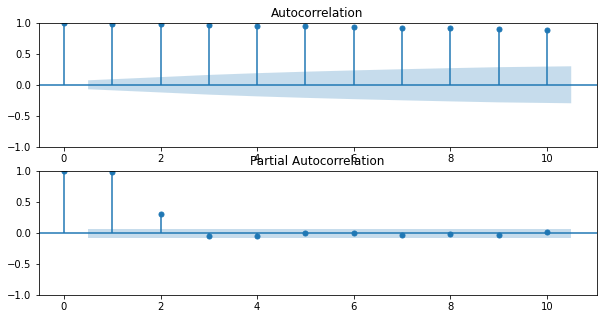

In [26]:
#ACF and PACF plots for AR 1 model
fig, ax = plt.subplots(2,1, figsize=(10,5))
plot_acf(daily, lags=10, ax=ax[0])
plot_pacf(daily, lags=10, ax=ax[1])
plt.show()

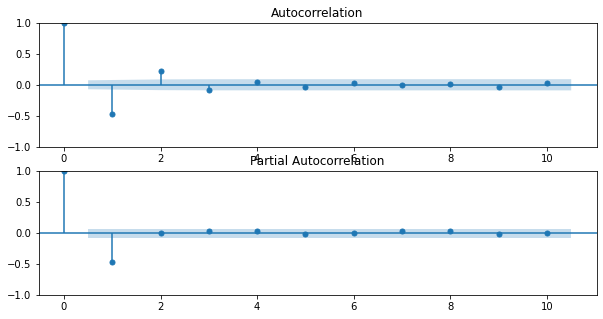

In [27]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
plot_acf(daily_diff, lags=10, ax=ax[0])
plot_pacf(daily_diff, lags=10, ax=ax[1])
plt.show()

In [28]:
#autocorrelation function
daily_diff['Revenue'].autocorr(), daily['Revenue'].autocorr()

(-0.4696890672062501, 0.9902917999411424)

The absolute value of each autocorrelation coefficient is less than 0.5, which means there is no autocorrelation after differencing. The ACF and PACF plots show that the data is not autocorrelated.

•   spectral density


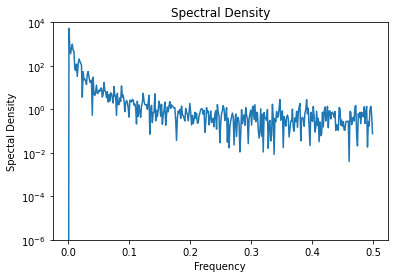

In [29]:
#spectral density
from scipy import signal
f, Pxx_den = signal.periodogram(daily['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e4])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

In [30]:
daily.mean(), daily.std()

(Revenue    9.822901
 dtype: float64,
 Revenue    3.852645
 dtype: float64)

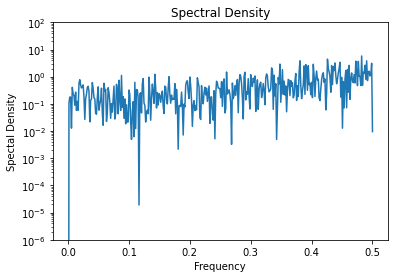

In [31]:
f, Pxx_den = signal.periodogram(daily_diff['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

In [32]:
daily_diff.mean(), daily_diff.std()

(Revenue    0.022768
 dtype: float64,
 Revenue    0.535507
 dtype: float64)

For daily data, there is no dominant frequency after differencing, meaning the ARIMA model will need to be used with a d=1 to have the best results. This will be verified with pdmarima machine learning function to verify. The data is white noise.

•   the decomposed time series


In [33]:
#import seasonal_decompose and decomp_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
#decompose daily data
daily_decomp = seasonal_decompose(daily)
dailytrend = daily_decomp.trend
dailyseasonal = daily_decomp.seasonal
dailyresidual = daily_decomp.resid
daily_decomp

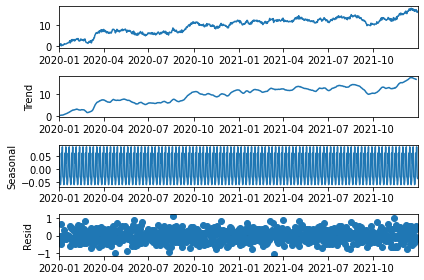

In [35]:
#plot daily data
daily_decomp.plot()
plt.show()

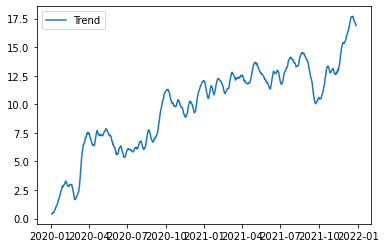

In [36]:
plt.plot(dailytrend, label='Trend')
plt.legend(loc='best')
plt.show()

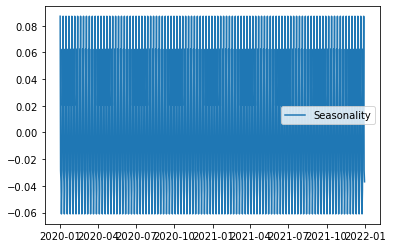

In [37]:
plt.plot(dailyseasonal, label='Seasonality')
plt.legend(loc='best')
plt.show()

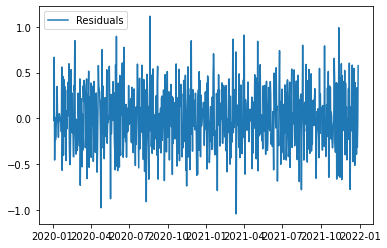

In [38]:
plt.plot(dailyresidual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [39]:
#decompose monthly data
diff_decomp = seasonal_decompose(daily_diff, model='additive')
difftrend = diff_decomp.trend
diffseasonal = diff_decomp.seasonal
diffresidual = diff_decomp.resid

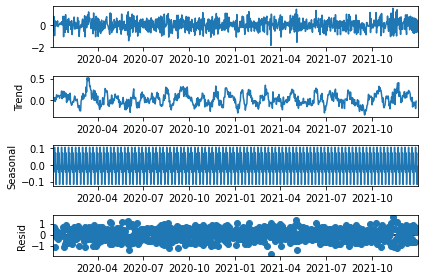

In [40]:
diff_decomp.plot()
plt.show()

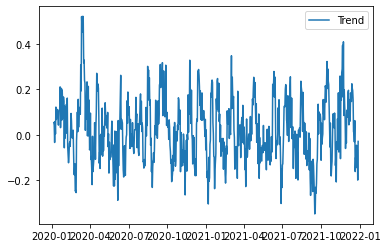

In [41]:
plt.plot(difftrend, label='Trend')
plt.legend(loc='best')
plt.show()

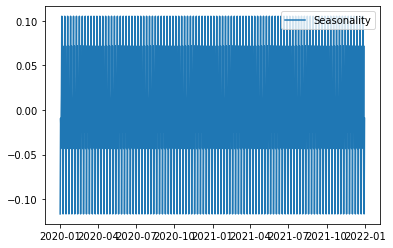

In [42]:
plt.plot(diffseasonal, label='Seasonality')
plt.legend(loc='best')
plt.show()

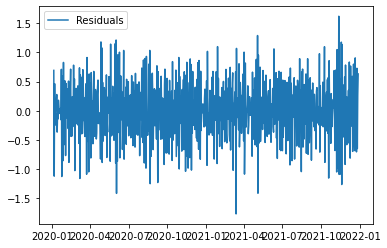

In [43]:
plt.plot(diffresidual, label='Residuals')
plt.legend(loc='best')
plt.show()

•   confirmation of the lack of trends in the residuals of the decomposed series

The non differenced dataset is showing a positive trend that is eliminated with a diff(1) approach.

### 2.  Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.


PMDArima library has built an autoarima grid-search like optimizer to choose p,q, and d for the Arima model and chooses the ones with the best score. The model is then fit to the data and the summary is printed. The model is then plotted to show the residuals and the model is then evaluated with the AIC and BIC scores.

In [44]:
#identify ARIMA model via auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

auto_arima(dailytrain, start_p=2, d=None, start_q=2, max_p=6, max_d=3, max_q=6,
           start_P=1, D=None, start_Q=1, max_P=3, max_D=2, max_Q=3, m=7,
              seasonal=True, stationary=False, information_criterion='aic',
                alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True,
                suppress_warnings=True, error_action='ignore', trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=912.455, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=777.146, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=802.713, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=911.523, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=775.277, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=777.146, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=779.146, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=777.262, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=777.265, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=800.798, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=779.077, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=776.233, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[7] intercept
Total fit time: 2.454 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True)

Interestingly, the auto_arima functio0n determines that d=3 for the lags for the best model on the non differenced data

In [45]:
auto_arima(dailydiftrain, seasonal=10,
           d=1, trace=True,stationary=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=779.322, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=912.455, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=775.277, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=800.798, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=911.523, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=777.262, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=777.265, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=779.077, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=776.233, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.702 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

As expected, AR(1) is the best for the stationary data

In [46]:
#instantiate ARIMA model
dailymod = sm.tsa.arima.ARIMA(dailytrain, order=(1,1,0), seasonal_order=(0,0,0,7))
dailydifmod = sm.tsa.arima.ARIMA(dailydiftrain, order=(1,0,0))

In [47]:
#fit ARIMA model
dailyresults = dailymod.fit()
difresults = dailydifmod.fit()

In [48]:
#summary of ARIMA models
print(dailyresults.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  586
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -386.116
Date:                Sun, 16 Oct 2022   AIC                            776.233
Time:                        11:43:22   BIC                            784.976
Sample:                    01-01-2020   HQIC                           779.640
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4573      0.036    -12.621      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.967      0.000       0.192       0.246
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [49]:
print(difresults.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -384.638
Date:                Sun, 16 Oct 2022   AIC                            775.277
Time:                        11:43:23   BIC                            788.392
Sample:                    01-02-2020   HQIC                           780.388
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.013      1.717      0.086      -0.003       0.049
ar.L1         -0.4601      0.036    -12.665      0.000      -0.531      -0.389
sigma2         0.2180      0.014     16.032      0.0

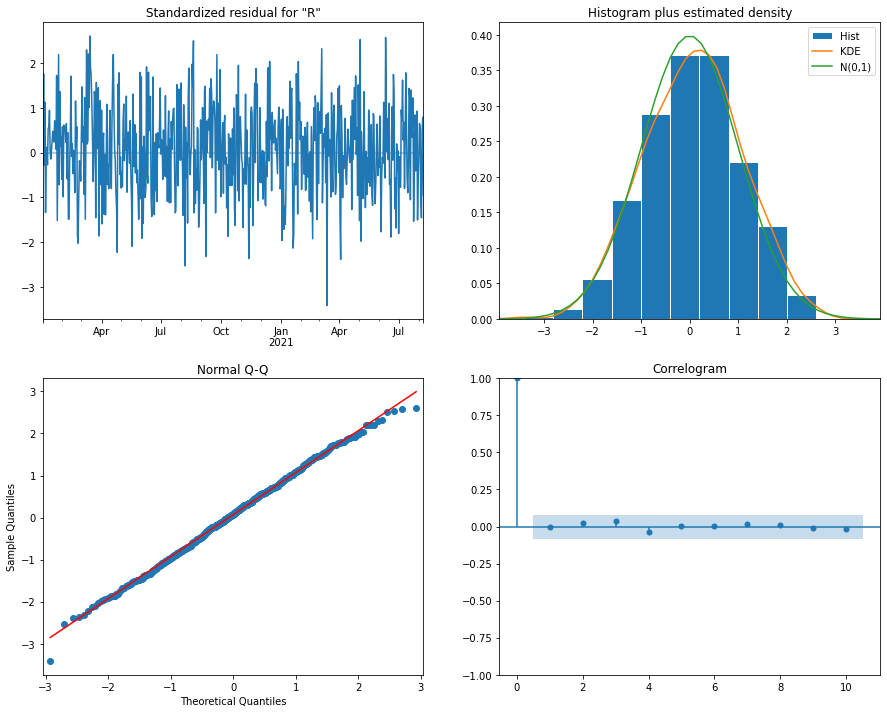

In [50]:
#diagostic plots
dailyresults.plot_diagnostics(figsize=(15, 12))
plt.show()

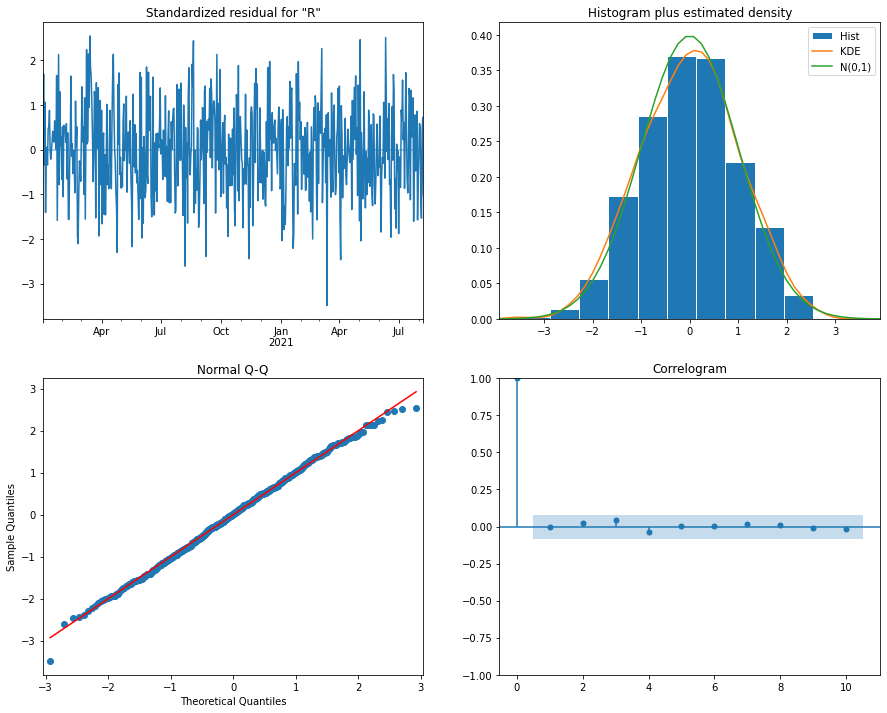

In [51]:
difresults.plot_diagnostics(figsize=(15, 12))
plt.show()

### 3.  Perform a forecast using the derived ARIMA model.


In [52]:
#forecast daily data
from statsmodels.graphics.tsaplots import plot_predict

In [53]:
#ARIMAX predictions

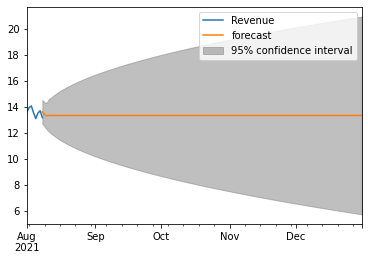

In [54]:
fig, ax = plt.subplots()
dailytrain.loc['2021-08-01':].plot(ax=ax)
plot_predict(dailyresults, start='2021-08-08', end='2021-12-31', ax=ax)
plt.show()

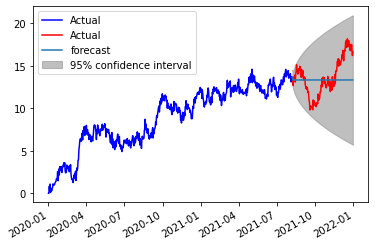

In [55]:
fig, ax = plt.subplots()
plt.plot(dailytrain, label='Actual', color='blue')
plt.plot(dailytest, label='Actual', color='red')
plot_predict(dailyresults, start='2021-08-08', end='2021-12-31', ax=ax)
plt.show()

In [56]:
#Sarimax model
model_sar = sm.tsa.SARIMAX(dailytrain['Revenue'], order=(1, 0, 3))
sar_results = model_sar.fit()     
sar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  586
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -388.587
Date:                Sun, 16 Oct 2022   AIC                            787.175
Time:                        11:43:23   BIC                            809.042
Sample:                    01-01-2020   HQIC                           795.696
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.001   1022.084      0.000       0.997       1.001
ma.L1         -0.4567      0.040    -11.321      0.000      -0.536      -0.378
ma.L2          0.2380      0.044      5.452      0.000       0.152       0.324
ma.L3         -0.0639      0.041     -1.547      0.122      -0.145       0.017
sigma2         0.2182      0.014     15.708      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.87   Prob(JB):                         0.25
Heteroskedasticity (H):               0.97   Skew:                            -0.10
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
#forecast via sarimax
sar_pred = sar_results.predict(585, 730, typ = 'levels').rename('Predictions')

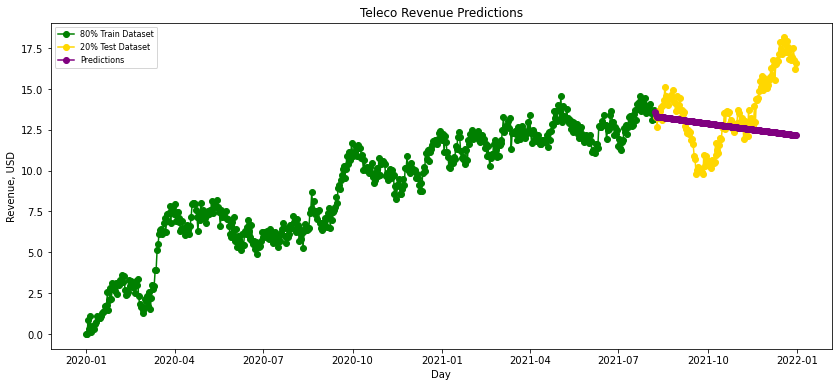

In [61]:
plt.figure(figsize=(14, 6))
plt.plot(dailytrain['Revenue'], 'o-', color='Green', label = '80% Train Dataset')
plt.plot(dailytest['Revenue'], 'o-',  color='Gold', label = '20% Test Dataset')
plt.plot(sar_pred, 'o-', color='Purple', label = 'Predictions')
plt.title('Teleco Revenue Predictions')
plt.xlabel('Day')
plt.ylabel('Revenue, USD')
plt.legend(loc='best', fontsize = 8)
plt.show()

The Sarimax and Arima model showing the same results. Useing the SARIMAX model, another quarter data will be calculated

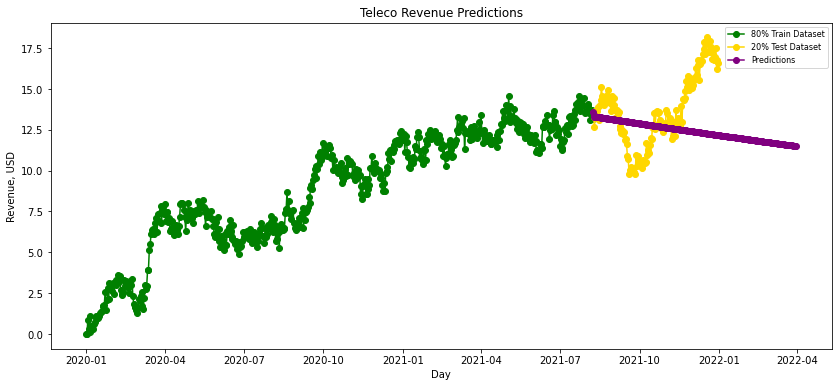

In [59]:
sar_pred = sar_results.predict(585, 820, typ = 'levels').rename('Predictions')
plt.figure(figsize=(14, 6))
plt.plot(dailytrain['Revenue'], 'o-', color='Green', label = '80% Train Dataset')
plt.plot(dailytest['Revenue'], 'o-',  color='Gold', label = '20% Test Dataset')
plt.plot(sar_pred, 'o-', color='Purple', label = 'Predictions')
plt.title('Teleco Revenue Predictions')
plt.xlabel('Day')
plt.ylabel('Revenue, USD')
plt.legend(loc='best', fontsize = 8)
plt.show()

### 4.  Provide the output and calculations of the analysis you performed.


All code provided in line above

### 5.  Provide the code used to support the implementation of the time series model.



All code provided in line.

# References

https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests

PraveenPraveen, et al. “Contradictory Results of ADF and KPSS Unit Root Tests.” Cross Validated, 1 Oct. 2022, https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests.